In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [2]:
INPUT_SHAPE = (128, 128, 3)
InputLayer = tf.keras.layers.Input(shape=INPUT_SHAPE)

In [3]:
# Rotating image

group1 = tf.keras.layers.Flatten(name="rotating_block")(InputLayer)
group1 = tf.keras.layers.Dense(128, activation=tf.keras.layers.ReLU())(group1)
group1 = tf.keras.layers.BatchNormalization()(group1)
group1 = tf.keras.layers.Dense(64, activation=tf.keras.layers.ReLU())(group1)
group1 = tf.keras.layers.Dense(16, activation=tf.keras.layers.ReLU())(group1)
group1 = tf.keras.layers.BatchNormalization()(group1)

In [4]:
# Color Image

group2 = tf.keras.layers.Flatten(name="color_block")(InputLayer)
group2 = tf.keras.layers.Dense(128, activation=tf.keras.layers.ReLU())(group2)
group2 = tf.keras.layers.Dense(64, activation=tf.keras.layers.ReLU())(group2)
group2 = tf.keras.layers.Dense(3, activation=tf.keras.layers.ReLU())(group2)
group2 = tf.keras.layers.BatchNormalization()(group2)

In [5]:
# Features Image

vgg = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)

for layer in vgg.layers:
    layer.trainable = False

group3 = vgg(InputLayer)
group3 = tf.keras.layers.Flatten(name="features_block")(group3)
group3 = tf.keras.layers.Dense(128, activation=tf.keras.layers.ReLU())(group3)
group3 = tf.keras.layers.Dense(64, activation=tf.keras.layers.ReLU())(group3)

In [6]:
_sum = tf.keras.layers.Concatenate(name="margination")([group1, group2, group3])

encoding = tf.keras.layers.Dense(128, activation=tf.keras.layers.ReLU())(_sum)
encoding = tf.keras.layers.Dropout(0.5)(encoding)
encoding = tf.keras.layers.Dense(64, activation=tf.keras.layers.ReLU())(encoding)

TensorShape([None, 64])

In [7]:
decoding = tf.keras.layers.Dense(128*128*3, activation=tf.keras.layers.ReLU())(encoding)

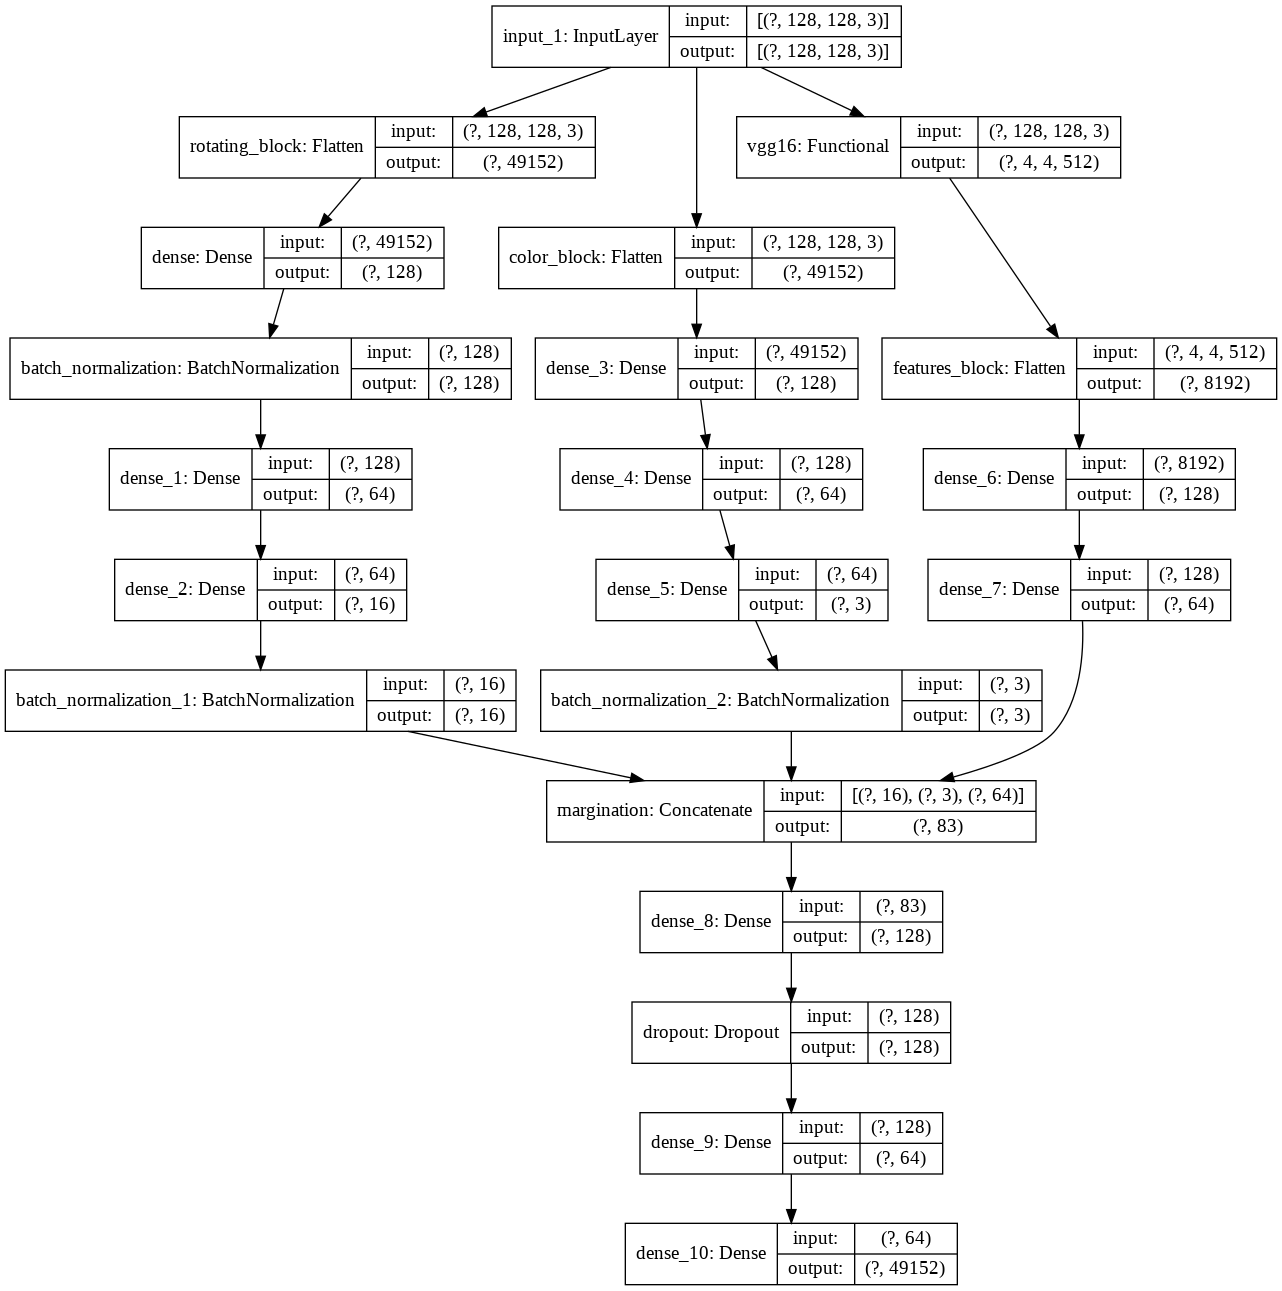

In [8]:
model = tf.keras.models.Model(InputLayer, decoding)
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.5))
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
import cv2 as cv
import numpy as np
import os

In [10]:
open("downloadData.sh", "w").write("""
links=("https://cdn.glitch.com/c16f71ef-e58b-4291-89f3-62975c2ebc7f%2Fcat.zip?v=1603374297531"\
       "https://cdn.glitch.com/c16f71ef-e58b-4291-89f3-62975c2ebc7f%2Fdog.zip?v=1603374302423"\
       "https://cdn.glitch.com/c16f71ef-e58b-4291-89f3-62975c2ebc7f%2Fgirl.zip?v=1603374306758" )

for link in ${links[@]};
do
    name=$(echo $link | grep -Po "[a-z]+\.zip")
    curl ${link} --output ${name}
    unzip -o ${name}
done
""")
os.system("bash downloadData.sh; rm downloadData.sh")


def fixed_image(img):
    result = []
    for rotating in [None,
                     cv.cv2.ROTATE_90_CLOCKWISE,
                     cv.ROTATE_90_COUNTERCLOCKWISE,
                     cv.ROTATE_180]:
        for position in range(3):
            if rotating:
                temp = cv.rotate(cv.resize(img, INPUT_SHAPE[:-1]), rotating)
            temp = cv.resize(img, INPUT_SHAPE[:-1])
            temp[:,:,position] = 0
            result.append(temp)
    return np.array(result)

X = []
Y = []

for file in os.listdir():
    if ".zip" in file:
        
        # os.system(f"unzip {file}")
        print(f"process: {file:<10}", end="")
        
        for value in [cv.imread(f"{file[:-4]}/images/{img}") 
                      for img in os.listdir(f"{file[:-4]}/images/")]:
            X.append(fixed_image(value))
            Y.append((cv.resize(value, INPUT_SHAPE[:-1]).flatten(),)*len(X[-1]))
        print("[OK]")
        
X = np.concatenate(X)
Y = np.concatenate(Y)
print(X.shape, Y.shape)

process: dog.zip   [OK]
process: girl.zip  [OK]
process: cat.zip   [OK]
(22308, 128, 128, 3) (22308, 49152)


In [ ]:
model.fit(X, Y, steps_per_epoch=1024,epochs=64)